In [53]:
!wandb login 55d09ffedb7a5b9c08dfddc17d834220dbf0bfa4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/katrindar/.netrc


In [54]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


In [55]:
# # Initialize W&B project (done once)
# wandb.init(project="wildfire-prediction")
# wandb.finish()

In [56]:
def display_random_sample(dataset_dir):
    classes = [
        class_name for class_name in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, class_name))
    ]
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_dir)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        if not image_files:
            continue

        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        img = load_img(img_path)
        
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")
    plt.show()


Training set samples:


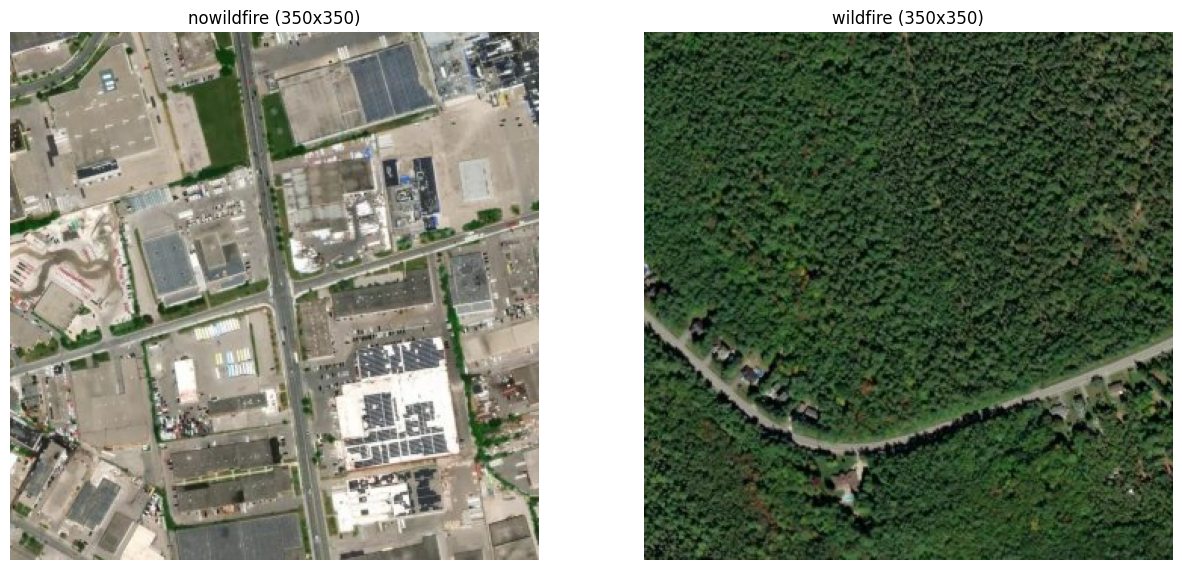

Validation set samples:


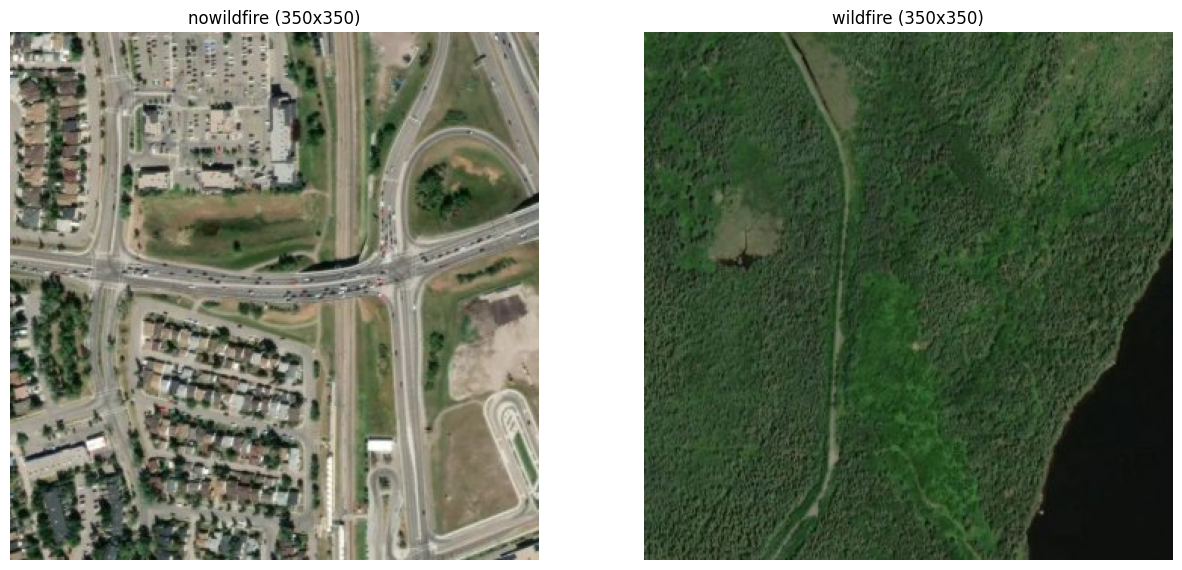

Test set samples:


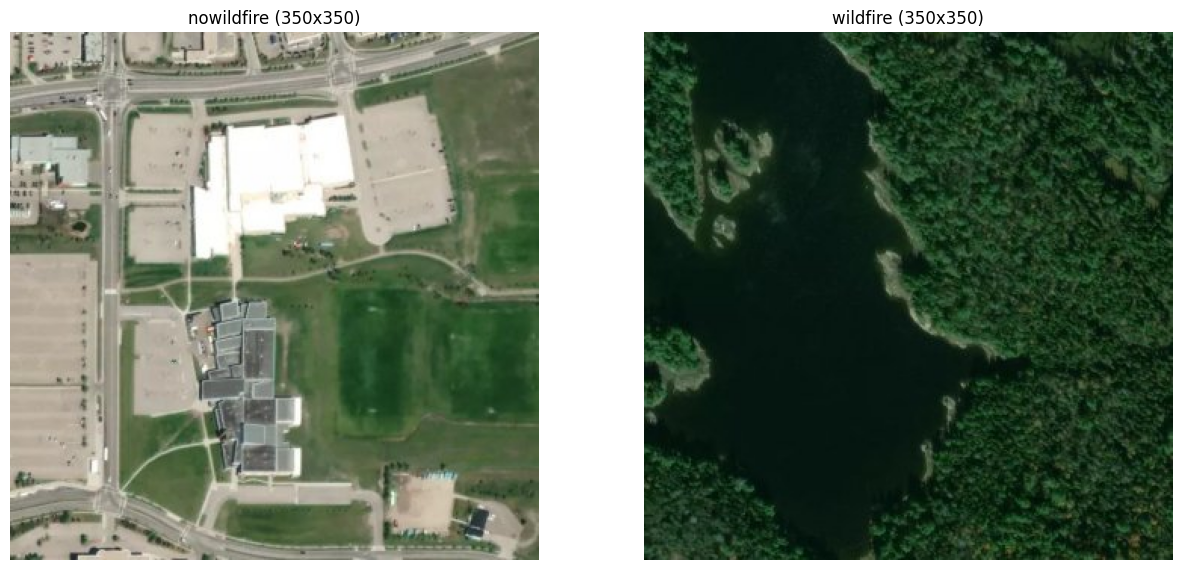

In [57]:
train_dir = 'fire_data/train'
valid_dir = 'fire_data/valid'
test_dir = 'fire_data/test'

print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [58]:
def load_data(directory, img_size=(32, 32)):
    X, Y = [], []
    for direct in os.listdir(directory):
        direct_path = os.path.join(directory, direct)
        if not os.path.isdir(direct_path):
            continue
        for filename in os.listdir(direct_path):
            img_path = os.path.join(direct_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            Y.append(direct)
    return np.array(X), np.array(Y)

x_train, y_train = load_data(train_dir)
x_val, y_val = load_data(valid_dir)
x_test, y_test = load_data(test_dir)

# Convert labels to binary
y_train = np.array([1 if label == 'wildfire' else 0 for label in y_train])
y_val = np.array([1 if label == 'wildfire' else 0 for label in y_val])
y_test = np.array([1 if label == 'wildfire' else 0 for label in y_test])

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

Premature end of JPEG file
Premature end of JPEG file


x_train shape: (30250, 32, 32, 3)
x_val shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_val shape: (6300,)
y_test shape: (6300,)


In [59]:
def build_model(input_shape, conv_layers, conv_filters, dense_units, dropout_rate, activation, optimizer, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for i in range(conv_layers):
        model.add(Conv2D(conv_filters[i], (3, 3), padding='same', activation=activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized")

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(threshold=0.45)]
    )
    return model

In [60]:
sweep_config = {
    'method': 'bayes',  # could be 'grid', 'random'
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'conv_layers': {
            'values': [1, 2]
        },
        'dense_units': {
            'values': [64, 128, 256]
        },
        'dropout_rate': {
            'values': [0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'epochs': {
            'values': [20, 30, 40]
        }
    }
}

In [61]:
sweep_id = wandb.sweep(sweep_config, project="wildfire-sweep")

Create sweep with ID: yxq6se9l
Sweep URL: https://wandb.ai/katrinpochtar/wildfire-sweep/sweeps/yxq6se9l


In [62]:
# # Define hyperparameter grids to generate ~150 experiments
# conv_layer_options = [1, 2]                     # 2 options
# dense_units_options = [64, 128, 256]            # 3 options
# dropout_options = [0.2, 0.3]                    # 2 options
# learning_rates = [0.001, 0.0001]                # 2 options
# optimizers = ['adam', 'sgd']                    # 2 options (reduced from 3 to control experiment count)
# epochs_options = [20, 30, 40]                   # 3 options

# experiment_configs = []

# for conv_layers in conv_layer_options:
#     for dense_units in dense_units_options:
#         for dropout_rate in dropout_options:
#             for lr in learning_rates:
#                 for optimizer in optimizers:
#                     for ep in epochs_options:
#                         exp = {
#                             "conv_layers": conv_layers,
#                             "conv_filters": [32]*conv_layers,  # Keep filter sizes uniform for simplicity
#                             "dense_units": dense_units,
#                             "dropout_rate": dropout_rate,
#                             "activation": "relu",
#                             "optimizer": optimizer,
#                             "learning_rate": lr,
#                             "batch_size": 32,
#                             "epochs": ep
#                         }
#                         experiment_configs.append(exp)

# print(f"Number of experiments: {len(experiment_configs)}")

In [ ]:
def train():
  
    wandb.init(project="wildfire-sweep")
    config = wandb.config
    
    conv_layers = config.conv_layers
    conv_filters = [32]*conv_layers  # Keep simple
    dense_units = config.dense_units
    dropout_rate = config.dropout_rate
    activation = 'relu'
    optimizer = config.optimizer
    learning_rate = config.learning_rate
    epochs = config.epochs
    batch_size = 32

    model = build_model(
        input_shape=(32,32,3),
        conv_layers=conv_layers,
        conv_filters=conv_filters,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[WandbMetricsLogger(), WandbModelCheckpoint("model.keras"), early_stopping],
        verbose=1
    )

    # Evaluate on test data
    test_predictions = model.predict(x_test)
    y_pred = (test_predictions > 0.45).astype("int32").ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')

    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1_score": f1
    })
    wandb.finish()

In [ ]:
wandb.agent(sweep_id, function=train, count=200)

wandb: Agent Starting Run: ijcoufm8 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Run ijcoufm8 errored:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
    model = build_model(
            ^^^^^^^^^^^^
TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

wandb: ERROR Run ijcoufm8 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
wandb: ERROR     model = build_model(
wandb: ERROR             ^^^^^^^^^^^^
wandb: ERROR TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

Run a8jt1ezz errored:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
    model = build_model(
            ^^^^^^^^^^^^
TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

wandb: ERROR Run a8jt1ezz errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
wandb: ERROR     model = build_model(
wandb: ERROR             ^^^^^^^^^^^^
wandb: ERROR TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

Run qmxfqzfc errored:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
    model = build_model(
            ^^^^^^^^^^^^
TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

wandb: ERROR Run qmxfqzfc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_15047/2645160038.py", line 16, in train
wandb: ERROR     model = build_model(
wandb: ERROR             ^^^^^^^^^^^^
wandb: ERROR TypeError: build_model() got an unexpected keyword argument 'optimizer_name'

In [65]:
# # Run the experiments
# for i, config in enumerate(experiment_configs):
#     print(f"Starting experiment {i+1}/{len(experiment_configs)} with config: {config}")
#     wandb.init(project="wildfire-prediction", config=config, reinit=True)
    
#     model = build_model(
#         input_shape=(32,32,3),
#         conv_layers=config["conv_layers"],
#         conv_filters=config["conv_filters"],
#         dense_units=config["dense_units"],
#         dropout_rate=config["dropout_rate"],
#         activation=config["activation"],
#         optimizer=config["optimizer"],
#         learning_rate=config["learning_rate"]
#     )
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
#     model.fit(
#         x_train, y_train,
#         validation_data=(x_val, y_val),
#         batch_size=config["batch_size"],
#         epochs=config["epochs"],
#         callbacks=[
#             WandbMetricsLogger(),
#             WandbModelCheckpoint(filepath="model.keras"),
#             early_stopping
#         ],
#         verbose=1
#     )
    
#     # Evaluate on test data
#     test_predictions = model.predict(x_test)
#     y_pred = (test_predictions > 0.45).astype("int32").ravel()

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='binary')
#     recall = recall_score(y_test, y_pred, average='binary')
#     f1 = f1_score(y_test, y_pred, average='binary')

#     wandb.log({
#         "test_accuracy": accuracy,
#         "test_precision": precision,
#         "test_recall": recall,
#         "test_f1_score": f1
#     })

#     wandb.finish()